In [1]:
import os
import warnings
import sys

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree, preprocessing, metrics, model_selection
import mlflow
import mlflow.sklearn

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


# Leitura dos Dados de Classificação de Vinhos 

In [4]:
df_wine = pd.read_csv('../data/dataset_vinhos.csv',sep=';')
wine_target_col = 'target'
wine_label_map = df_wine[['target', 'target_label']].drop_duplicates()
drop_cols = ['target_label']
df_wine.drop(drop_cols, axis=1, inplace=True)
print(df_wine.shape)
df_wine.head()

(5320, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,red
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0,red


## Codificação 

In [5]:
categorical_cols = ['type']
encoder_map = {}

for cname in categorical_cols:
    encoder = preprocessing.OneHotEncoder(sparse=False)
    transformed = encoder.fit_transform(df_wine[[cname]])
    ohe_df = pd.DataFrame(transformed, columns=[cname+'_'+cat for cat in encoder.categories_[0]])
    encoder_map[cname] = encoder
    
    df_wine = pd.concat([df_wine, ohe_df], axis=1).drop(cname, axis=1)
df_wine.head()

Y = df_wine[wine_target_col]
X = df_wine.drop(wine_target_col, axis=1)
wine_feature_names = list(X.columns)

/home/ciodaro/anaconda3/envs/infnet/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Modelo de Classificação de Vinhos 

In [6]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Aula Modelos'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id


2024/03/05 19:21:08 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/03/05 19:21:08 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

## Salvar Modelo

In [7]:
model_name = 'mlflow_modelo_salvo'

# Configuracao
criterion = 'gini'
max_depth = 5
SEED = 10
# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2, random_state=SEED)
df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[wine_target_col] = ytrain
df_test[wine_target_col] = ytest
with mlflow.start_run(experiment_id=experiment_id, run_name = 'MLModelDeployment'):
    model_wine = tree.DecisionTreeClassifier(criterion=criterion, max_depth = max_depth, random_state=SEED)
    model_wine.fit(xtrain, ytrain)
    print("Decision Tree Classifier (criterion=%s, max_depth=%f):" % (criterion, max_depth))
    mlflow.sklearn.save_model(model_wine, model_name)    

Decisn Tree Classifier (criterion=gini, max_depth=5.000000):


## Seleção de Variáveis Importantes 

Top Features
 ['alcohol' 'volatile acidity' 'free sulfur dioxide' 'residual sugar']


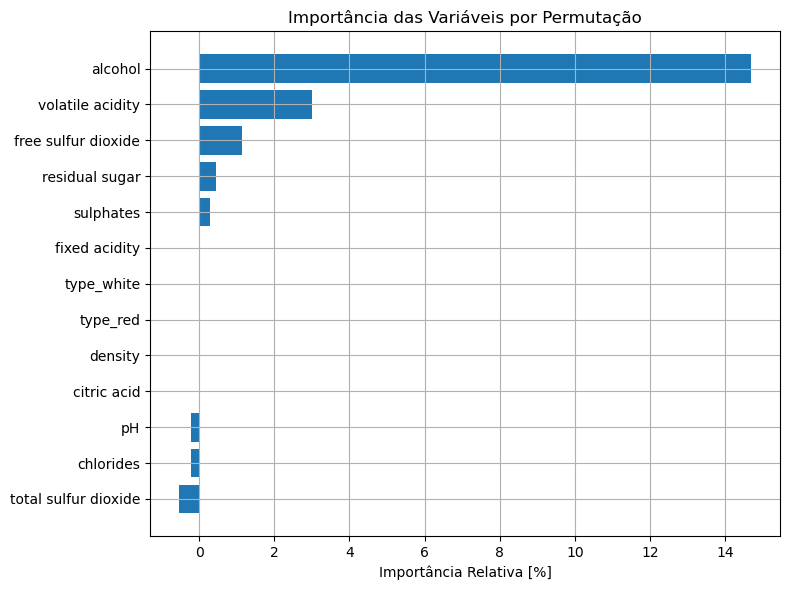

In [8]:
from sklearn.inspection import permutation_importance

ntop=4

plt.figure(figsize=(8,6))
r = permutation_importance(model_wine, xtest, ytest,
                           n_repeats=30,
                           random_state=0)
importance =  r.importances_mean
idx = np.argsort(importance)
plt.barh(np.arange(idx.shape[0]), importance[idx]*100)
plt.yticks(np.arange(idx.shape[0]), np.array(wine_feature_names)[idx])
plt.title('Importância das Variáveis por Permutação')
plt.grid()
plt.xlabel('Importância Relativa [%]')
plt.tight_layout()

top_features = np.array(wine_feature_names)[idx][::-1][:ntop]
print('Top Features\n',top_features)

# Modelo Com Assinatura e Exemplo de Entrada 

In [9]:
from mlflow.models.signature import infer_signature
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

model_name = 'mlflow_modelo_assinatura_com_exemplo'
Y = df_wine[wine_target_col]
X = df_wine[top_features]

nexamples = 4

# Configuracao
criterion = 'gini'
max_depth = 5
# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)
df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[wine_target_col] = ytrain
df_test[wine_target_col] = ytest
with mlflow.start_run(experiment_id=experiment_id, run_name = 'MLModelDeployment'):
    # mlflow.sklearn.autolog() # Precisa ser chamado antes do codigo do treinamento
    model_wine = tree.DecisionTreeClassifier(criterion=criterion, max_depth = max_depth)
    model_wine.fit(xtrain, ytrain)
    print("Decision Tree Classifier (criterion=%s, max_depth=%f):" % (criterion, max_depth))
    mlflow.sklearn.save_model(model_wine, model_name)
    
    # Assinatura do Modelo Inferida pelo MLFlow
    inf_signature = infer_signature(xtrain, model_wine.predict(xtrain))
    # Assinatura Manual, forçando tipos e descricoes.
    input_schema = Schema([
        ColSpec("double", "alcohol"),
        ColSpec("double", "volatile acidity"),
        ColSpec("double", "sulphates"),
        ColSpec("double", "residual sugar"),
    ])
    output_schema = Schema([
        ColSpec("integer", "classe predita")
    ])
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)
    # Print das assinaturas
    print('=== Assinatura Sugerida')
    print(inf_signature)
    print('=== Assinatura Explícita')
    print(signature)
    
    # Exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:nexamples] for x in top_features}
#     input_example = {
#         'alcohol': xtrain['alcohol'].values[:2],
#         'volatile acidity':  xtrain['volatile acidity'].values[:2],
#         'sulphates':  xtrain['sulphates'].values[:2],
#         'residual sugar':  xtrain['residual sugar'].values[:2],
#     }
    # Adicionar o exemplo como parametro do log
    mlflow.sklearn.log_model(model_wine,
                             model_name,
                             signature = inf_signature,
                             input_example = input_example)


Decisn Tree Classifier (criterion=gini, max_depth=5.000000):


/home/ciodaro/anaconda3/envs/infnet/lib/python3.8/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/ciodaro/anaconda3/envs/infnet/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


=== Assinatura Sugerida
inputs: 
  ['alcohol': double, 'volatile acidity': double, 'free sulfur dioxide': double, 'residual sugar': double]
outputs: 
  [Tensor('int64', (-1,))]
params: 
  None

=== Assinatura Explícita
inputs: 
  ['alcohol': double, 'volatile acidity': double, 'sulphates': double, 'residual sugar': double]
outputs: 
  ['classe predita': integer]
params: 
  None



/home/ciodaro/anaconda3/envs/infnet/lib/python3.8/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/ciodaro/anaconda3/envs/infnet/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [9]:
# mlflow.end_run()
#!mlflow ui
# Para usar o sqlite como repositorio
# mlflow ui --backend-store-uri sqlite:///mlruns.db

# Registro de Modelos

Treinamento e deployment de um modelo de classificador de vinhos tintos.

    1 - Filtragem dos dados de vinho branco e separação da base de operação
    2 - Treinamento de modelos padrão com o PyCaret (árvore, logística e SVM)
    3 - Registro do modelo e validaçãp para staging caso precisão mínima de 70%
    4 - Servir o modelo em staging para testes
    5 - Consumir o modelo por biblioteca requests com a base de operação
    6 - Consumir a base operação como uma aplicação python

## 1 - Filtrar Vinhos Tintos 

In [10]:
data_wine = df_wine[df_wine.type_red == 1].drop(['type_red', 'type_white'], axis=1)     
# Separar parte para compor a base de operacao
data_wine, data_operation, ytrain, ytest = model_selection.train_test_split(data_wine, 
                                                                        data_wine[wine_target_col],
                                                                        test_size=0.1)
data_wine[wine_target_col]      = ytrain
data_operation[wine_target_col] = ytest

# Base de vinhos brancos
data_white_wine = df_wine[df_wine.type_red == 0].drop(['type_red', 'type_white'], axis=1)

## 2 - Treinar Modelos com PyCaret 

In [38]:
import pycaret.classification as pc
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'classificador_vinho'

# train/test
s = pc.setup(data = data_wine, 
             target = wine_target_col,
             train_size=0.7,
             verbose = 0,
             log_experiment = True, 
             experiment_name = experiment_name, 
             log_plots = True)
models = ['lr', 'dt', 'rbfsvm']
bestmodel = pc.compare_models(include = models, sort='precision')
# Log do run, e nao do modelo respectivo
classification_plots = [ 'auc','pr','confusion_matrix',
#                          'error', 'class_report', 'threshold',
                         'learning',
                        # 'vc',
                        'feature',
                       ]
for plot_type in classification_plots:
    print('=> Aplicando plot ', plot_type)
    try:
        artifact = pc.plot_model(bestmodel, plot=plot_type, save=True)
        mlflow.log_artifact(artifact)
    except:
        print('=> Nao possivel plotar: ', plot_type )
        continue

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7406,0.8251,0.7182,0.7642,0.7390,0.4818,0.4843,0.2840
dt,Decision Tree Classifier,0.6706,0.6705,0.6705,0.6832,0.6755,0.3410,0.3427,0.0110
rbfsvm,SVM - Radial Kernel,0.6447,0.6999,0.6386,0.6600,0.6480,0.2895,0.2905,0.0440


=> Aplicando plot  auc


=> Aplicando plot  pr


=> Aplicando plot  confusion_matrix


=> Aplicando plot  learning


=> Aplicando plot  feature


## 3 - Registrar e Validar o Modelo Melhor Precisão

In [39]:
from mlflow.tracking import MlflowClient
mlflow.set_registry_uri("sqlite:///mlruns.db")

registered_model_name = 'modelo_vinho_tinto'
min_precision = 0.7
model_version = -1 # recuperar a ultima versao
nexamples = 4


# Test set
pred_holdout = pc.predict_model(bestmodel, raw_score=True)
pred_holdout['prediction_score'] = pred_holdout.prediction_score_1.values

pr = metrics.precision_score(pred_holdout[wine_target_col], pred_holdout['prediction_label'])
if pr > min_precision:
    print(f'=> Aceito o modelo com precisão {pr} (min: {min_precision})')
    # Pycaret exporta junto o pipeline de preprocessamento
    pc.save_model(bestmodel, f'./{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = pc.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(data_wine.drop(wine_target_col, axis=1).columns)
    inf_signature = infer_signature(data_wine[model_features], model_pipe.predict(data_wine.drop(wine_target_col, axis=1)))
    # Exemplo de entrada para o MLmodel
    input_example = {x: data_wine[x].values[:nexamples] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example
    )
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    # Registrar o modelo como staging
    client.transition_model_version_stage(
        name=registered_model_name,
        version=model_version, # Verificar com usuario qual versao
        stage="Staging"
    )

else:
    print(f'=> Rejeitado o modelo com precisão {pr} (min: {min_precision})')




,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7330,0.8231,0.7606,0.7296,0.7448,0.4650,0.4655


=> Aceito o modelo com precisão 0.7295918367346939 (min: 0.7)
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'modelo_vinho_tinto' already exists. Creating a new version of this model...
Created version '2' of model 'modelo_vinho_tinto'.


## 4 - Servir o Modelo com o MLFlow 

In [34]:
# import os
# os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'
# !mlflow models serve -m "models:/modelo_vinho_tinto/staging" --no-conda -p 5001

/home/ciodaro/anaconda3/envs/infnet/lib/python3.8/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.0/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])
2024/03/05 19:35:53 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
/home/ciodaro/anaconda3/envs/infnet/lib/python3.8/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://

## 6 - Consumir o Modelo com Exemplos 

### 6.1 - Dados Vinhos Tintos Operacao 

In [59]:
import requests
import json

host = 'localhost'
port = '5001'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json',}

inference_request = {
    "dataframe_split": json.loads(data_operation.drop(wine_target_col,axis=1).to_json(orient='split'))
}
r = requests.post(url=url, headers=headers, json=inference_request)

data_operation.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]

print(metrics.classification_report(data_operation[wine_target_col], data_operation['operation_label']))

              precision    recall  f1-score   support

           0       0.56      0.87      0.68        45
           1       0.91      0.66      0.76        91

    accuracy                           0.73       136
   macro avg       0.73      0.76      0.72       136
weighted avg       0.79      0.73      0.74       136



### 6.2 - Dados Vinhos Brancos 

In [60]:
import requests
host = 'localhost'
port = '5001'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json',}

inference_request = {
    "dataframe_split": json.loads(data_white_wine.drop(wine_target_col,axis=1).to_json(orient='split'))
}
r = requests.post(url=url, headers=headers, json=inference_request)

data_white_wine.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]

print(metrics.classification_report(data_white_wine[wine_target_col], data_white_wine['operation_label']))

              precision    recall  f1-score   support

           0       0.47      0.85      0.61      1348
           1       0.87      0.51      0.64      2613

    accuracy                           0.63      3961
   macro avg       0.67      0.68      0.62      3961
weighted avg       0.73      0.63      0.63      3961



## 7 - Utilizar Como uma Biblioteca da Aplicacao  

In [62]:
# mlflow.get_registry_uri()

model_uri = f"models:/modelo_vinho_tinto/staging"
loaded_model = mlflow.sklearn.load_model(model_uri)


http_data = data_operation.drop([wine_target_col, 'operation_label'],axis=1)
data_operation.loc[:, 'operation_label'] = loaded_model.predict(http_data)

print(metrics.classification_report(data_operation[wine_target_col], data_operation['operation_label']))


              precision    recall  f1-score   support

           0       0.56      0.87      0.68        45
           1       0.91      0.66      0.76        91

    accuracy                           0.73       136
   macro avg       0.73      0.76      0.72       136
weighted avg       0.79      0.73      0.74       136

